# Meat Freshness Classification

## Data Description

The dataset contains 2266 images of meat with different degrees of freshness: fresh, half-fresh and spoiled.

The dataset was taken from: https://www.kaggle.com/datasets/vinayakshanawad/meat-freshness-image-dataset?select=Meat+Freshness.v1-new-dataset.multiclass

## Data Loading

In [1]:
%%capture
! pip install albumentations==0.4.6

In [42]:
# importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import SubsetRandomSampler, Dataset, DataLoader
from torchvision.models import efficientnet_b0
import torchvision
from torchvision import datasets
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import copy
import random
import os
from tqdm.autonotebook import tqdm, trange

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download -d vinayakshanawad/meat-freshness-image-dataset

 98% 58.0M/59.4M [00:02<00:00, 43.0MB/s]
100% 59.4M/59.4M [00:02<00:00, 30.0MB/s]


In [7]:
%%capture
! unzip meat-freshness-image-dataset.zip

## Data Preprocessing

In [8]:
train_data_dir = '/content/Meat Freshness.v1-new-dataset.multiclass/train'
train_data = list(os.listdir(train_data_dir))
val_data_dir = '/content/Meat Freshness.v1-new-dataset.multiclass/valid'
val_data = list(os.listdir(val_data_dir))

In [9]:
# getting names of files with labels
for data in (train_data, val_data):
  for filename in data:
    if filename.endswith('csv'):
      print(filename)

_classes.csv
_classes.csv


In [10]:
train_df = pd.read_csv(os.path.join(train_data_dir, '_classes.csv'))
train_df.head()

filename   Fresh   Half-Fresh  \
0  SPOILED-207-_JPG.rf.4e9025c18a5ae21defb30242a6...       0            0   
1  SPOILED-261-_JPG.rf.4effa4dd0d8c2fe5579aa5859e...       0            0   
2  FRESH-202-_JPG.rf.4f13e1b8c1559b63d140d2942697...       1            0   
3  FRESH-721-_JPG.rf.4f770a93bd104098aa7ffb172a90...       1            0   
4  FRESH-904-_JPG.rf.4f66185dbff0f068ed39414bfdf1...       1            0   

    Spoiled  
0         1  
1         1  
2         0  
3         0  
4         0

In [11]:
# getting label for each image
train_labels = train_df.drop('filename', axis=1).idxmax(axis=1)
train_labels.head()

0     Spoiled
1     Spoiled
2       Fresh
3       Fresh
4       Fresh
dtype: object

In [12]:
# label encoding
label_dict = {'Spoiled': 0, 'Half-Fresh': 1, 'Fresh': 2}
label_to_class = {v: k for k, v in label_dict.items()}
train_labels = train_labels.apply(lambda x: label_dict[x.strip()])

In [13]:
# dropping unnecessary columns
train_df['label'] = train_labels
train_df.drop([' Spoiled', ' Half-Fresh', ' Fresh'], axis=1, inplace=True)
train_df.head()

filename  label
0  SPOILED-207-_JPG.rf.4e9025c18a5ae21defb30242a6...      0
1  SPOILED-261-_JPG.rf.4effa4dd0d8c2fe5579aa5859e...      0
2  FRESH-202-_JPG.rf.4f13e1b8c1559b63d140d2942697...      2
3  FRESH-721-_JPG.rf.4f770a93bd104098aa7ffb172a90...      2
4  FRESH-904-_JPG.rf.4f66185dbff0f068ed39414bfdf1...      2

In [14]:
# validation dataframe preprocessing
val_df = pd.read_csv(os.path.join(val_data_dir, '_classes.csv'))
val_labels = val_df.drop('filename', axis=1).idxmax(axis=1)
val_labels = val_labels.apply(lambda x: label_dict[x.strip()])
val_df['label'] = val_labels
val_df.drop([' Spoiled', ' Half-Fresh', ' Fresh'], axis=1, inplace=True)
val_df.head()

filename  label
0  HALF-FRESH-8-_JPG.rf.5bf1ec7ab3a5bca8b3a01bbd3...      1
1  FRESH-91-_JPG.rf.5ce4d7d669bae2d26735e4edf0a17...      2
2  FRESH-408-_JPG.rf.5ead7613098bae61f4a33fab1084...      2
3  FRESH-344-_JPG.rf.5e8ec1875092af8f909b876ee314...      2
4  HALF-FRESH-919-_JPG.rf.5f00a599bb9c9b7694db119...      1

In [15]:
# getting number of samples of each class
class_dist = train_df.groupby(by='label', as_index=False).count()
class_dist.sort_values(by='filename', inplace=True, ascending=False)
class_dist.rename(columns={'filename': 'quantity'}, inplace=True)
class_dist

label  quantity
2      2       675
1      1       630
0      0       510

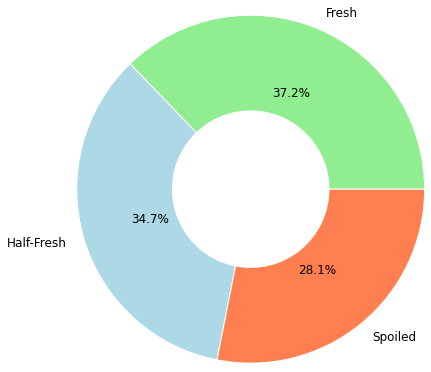

In [16]:
# visualizing class distribution
counts = class_dist['quantity']
labels = ['Fresh', 'Half-Fresh', 'Spoiled']

pie_plot, _, _ = plt.pie(counts,
                         radius=2.0,
                         labels=labels,
                         colors = ['lightgreen', 'lightblue', 'coral'],
                         autopct='%.1f%%',
                         textprops = {'fontsize': 12})
plt.setp(pie_plot, width=1.1, edgecolor='white')
plt.show()

It can be concluded that there is no significant class imbalance

In [17]:
# fucntion for images visualization
def show_images(images_filenames, images_dir, labels):
  rows = len(images_filenames)
  cols = 1
  figure, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 50))
  for i, image_filename in enumerate(images_filenames):
    image = cv2.imread(os.path.join(images_dir, image_filename))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    axes[i].imshow(image)
    axes[i].set_title(label_to_class[labels[i]])
    axes[i].set_axis_off()
  plt.tight_layout()
  plt.show()

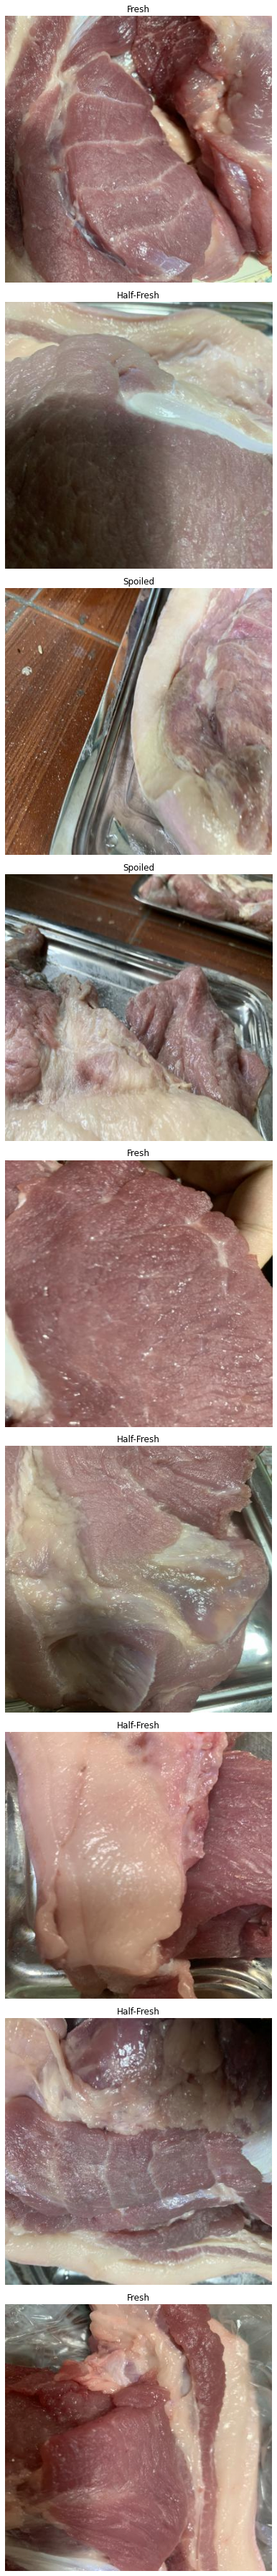

In [18]:
viz_df = train_df.sample(9, random_state=42)
show_images(viz_df['filename'].tolist(), train_data_dir, viz_df['label'].tolist())

In [19]:
# preparing dataset
class Meat_Dataset(Dataset):
  def __init__(self, images_filenames, images_dir, labels, transform=None):
    self.images_filenames = images_filenames
    self.images_dir = images_dir
    self.transform = transform
    self.labels = labels

  def __len__(self):
    return len(self.images_filenames)

  def __getitem__(self, index):
    image_filename = self.images_filenames[index]
    image = cv2.imread(os.path.join(self.images_dir, image_filename))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if self.transform:
      transformed = self.transform(image=image)
      image = transformed['image']
    label = self.labels[index]
    return image, label

In [20]:
# data augmentations
train_transform = A.Compose(
    [A.Resize(256, 256),
     A.HueSaturationValue(hue_shift_limit=0.1, sat_shift_limit= 0.1, val_shift_limit=0.1),
     A.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10),
     A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1),
     A.HorizontalFlip(),
     A.VerticalFlip(),
     A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
     ToTensorV2()])
val_transform = A.Compose(
    [A.Resize(256, 256),
     A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
     ToTensorV2()])

In [21]:
train_images_filenames = train_df['filename'].to_numpy()
train_labels = train_df['label'].to_numpy()
val_images_filenames = val_df['filename'].to_numpy()
val_labels = val_df['label'].to_numpy()

In [22]:
train_dataset = Meat_Dataset(train_images_filenames, train_data_dir, train_labels, transform=train_transform)
val_dataset = Meat_Dataset(val_images_filenames, val_data_dir, val_labels, transform=val_transform)

In [23]:
# splitting validation dataset into 2 parts to get test set
val_indexes, test_indexes = train_test_split(np.arange(len(val_labels)), test_size=0.1, shuffle=True, stratify=val_labels)
val_sampler = SubsetRandomSampler(val_indexes)
test_sampler = SubsetRandomSampler(test_indexes)

In [24]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, sampler=val_sampler)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, sampler=test_sampler)

In [25]:
# function for visualization of augmented images
def augmentation_viz(dataset, index=0, samples=5):
  dataset = copy.deepcopy(dataset)
  dataset.transform = A.Compose([i for i in dataset.transform if not isinstance(i, (A.Normalize, ToTensorV2))])
  fig, axes = plt.subplots(nrows=samples, ncols=1, figsize=(10, 30))
  for i in range(samples):
    image, label = dataset[index]
    axes[i].imshow(image)
    axes[i].set_title('Augmented_image')
    axes[i].set_axis_off()
  plt.tight_layout()
  plt.show()

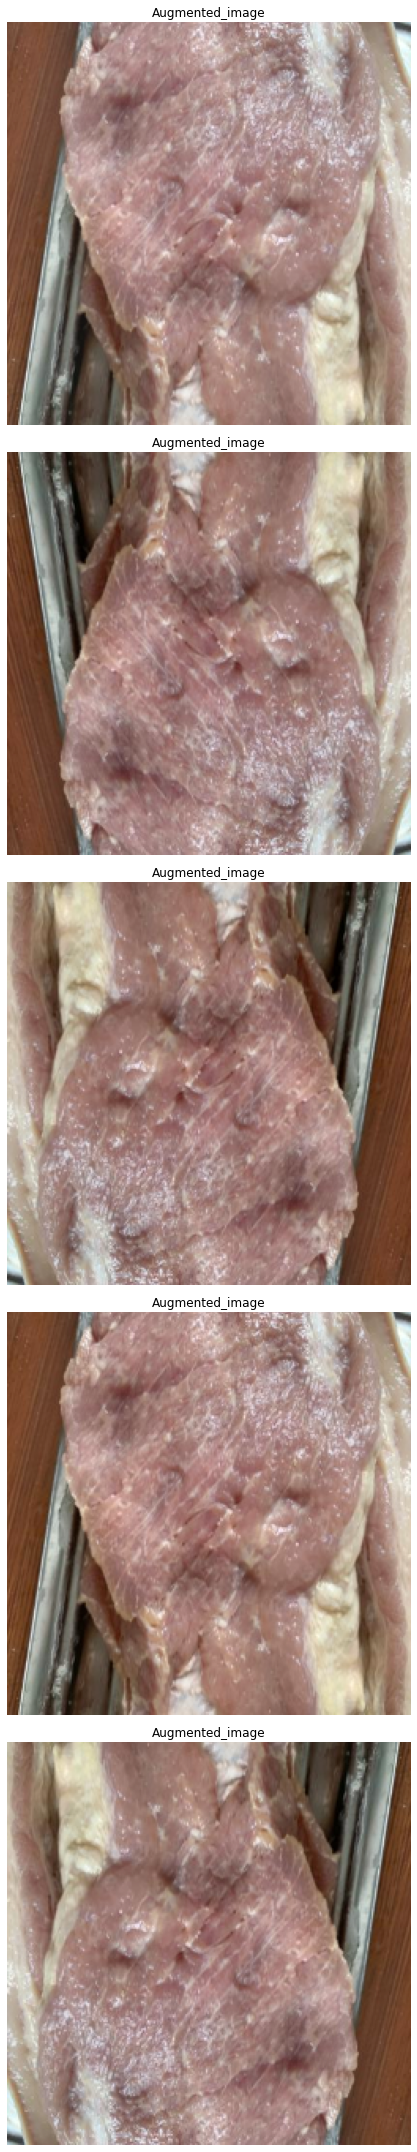

In [39]:
augmentation_viz(train_dataset, index=1)

## Model Training

In [32]:
# loading model
model = efficientnet_b0(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [33]:
# freezing model parameters and changing the last layer
for parameter in model.parameters():
  parameter.requires_grad = False
model.classifier[1] = nn.Linear(1280, 3)

In [39]:
# preparing optimizer and learning rate scheduler
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[1].parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [36]:
data_loaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_indexes)}

In [37]:
# fucntion for neural network training
def train_network(model, criterion, optimizer, scheduler, n_epochs):
  losses = {'train': [], 'val': []}
  accuracies = {'train': [], 'val': []}
  best_accuracy = 0.0
  best_weights = copy.deepcopy(model.state_dict())
  progress_bar = trange(n_epochs, desc='Epoch:')
  for epoch in progress_bar:
    for mode in ['train', 'val']:
      if mode == 'train':
        model.train()
      else:
        model.eval()
      running_loss = 0.0
      running_corrects = 0
      for data in tqdm(data_loaders[mode], leave=False, desc=f'{mode} iter:'):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        if mode == 'train':
          optimizer.zero_grad()
          outputs = model(inputs)
        elif mode == 'val':
          with torch.no_grad():
            outputs = model(inputs)
        preds = torch.argmax(outputs, -1)
        loss = criterion(outputs, labels)
        if mode == 'train':
          loss.backward()
          optimizer.step()
        running_loss += loss.item()
        running_corrects += int(torch.sum(preds == labels.data))
      if mode == 'train':
        scheduler.step()
      epoch_loss = running_loss / dataset_sizes[mode]
      epoch_acc = running_corrects / dataset_sizes[mode]
      losses[mode].append(epoch_loss)
      accuracies[mode].append(epoch_acc)
      progress_bar.set_description('{} Loss: {:.3f} Accuracy {:.3f}'.format(mode, epoch_loss, epoch_acc))
      if mode == 'val' and epoch_acc > best_accuracy:
        best_accuracy = epoch_acc
        best_weights = copy.deepcopy(model.state_dict())
  model.load_state_dict(best_weights)
  print('Best validation accuracy: {:.3f}'.format(best_accuracy))
  return model, losses

In [40]:
model, losses = train_network(model, loss_func, optimizer, scheduler, n_epochs=12)

Epoch::   0%|          | 0/12 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/13 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/13 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/13 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/13 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/13 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/13 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/13 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/13 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/13 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/13 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/13 [00:00<?, ?it/s]

train iter::   0%|          | 0/57 [00:00<?, ?it/s]

val iter::   0%|          | 0/13 [00:00<?, ?it/s]

Best validation accuracy: 0.968


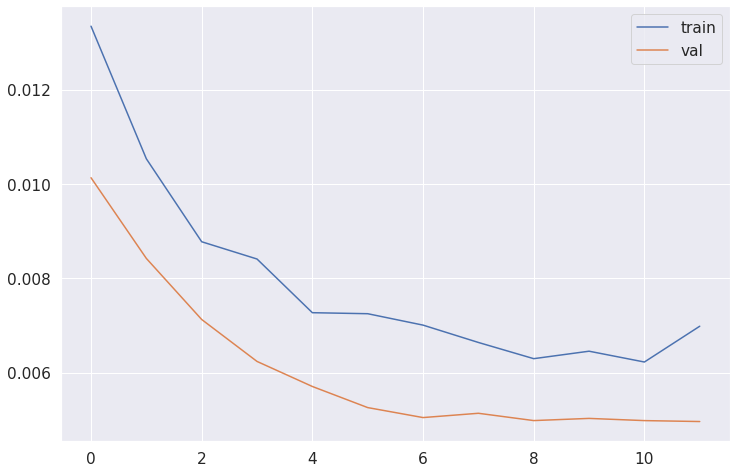

In [41]:
# visualizing model performance
sns.set(style='darkgrid', font_scale=1.4)
plt.figure(figsize=(12, 8))
plt.plot(losses['train'], label='train')
plt.plot(losses['val'], label='val')
plt.legend()
plt.show()

## Inference

In [51]:
# function for model performance evaluation on unseen data
def evaluate_network(model):
    test_accuracy = 0
    test_precision = 0
    test_recall = 0
    test_f1 = 0
    with torch.no_grad():
        for test_inputs, test_labels in tqdm(test_loader, leave=False):
            test_inputs = test_inputs.to(device)
            test_labels = test_labels.type(torch.LongTensor)
            test_labels = test_labels.to(device)
      
            outputs = model(test_inputs)
            preds = outputs.argmax(dim=1)

            test_accuracy += accuracy_score(test_labels.cpu(), preds.cpu())
            test_precision += precision_score(test_labels.cpu(), preds.cpu(), average='micro')
            test_recall += recall_score(test_labels.cpu(), preds.cpu(), average='micro')
            test_f1 += f1_score(test_labels.cpu(), preds.cpu(), average='micro')
    
    print(f'Test accuracy: {test_accuracy / len(test_loader): .3f}')
    print(f'Test precision: {test_precision / len(test_loader): .3f}')
    print(f'Test recall: {test_recall / len(test_loader): .3f}')
    print(f'Test f1: {test_f1 / len(test_loader): .3f}')

In [52]:
evaluate_network(model)

  0%|          | 0/2 [00:00<?, ?it/s]

Test accuracy:  1.000
Test precision:  1.000
Test recall:  1.000
Test f1:  1.000
